In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!pip install tqdm
#!pip install "coffea==0.7.22"
#!pip install "numpy>=1.22"
%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [33]:
import torch
import os
from torch.utils.data import DataLoader
import numpy as np 
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt
#from analysis.ttbarML.options import handleOptions
from options import handleOptions
#from utils.options import handleOptions
#from analysis.ttbarML.metrics import net_eval
from metrics import net_eval
#from utils.metrics import net_eval
import torch.nn as nn

mport torchvision.models as models

In [34]:
from torch.profiler import profile, record_function, ProfilerActivity

In [35]:
def save_and_plot(net, loss_test, loss_train, label, test_input, test_feat, feature_division, norm_test, norm_targ, show=False):
    '''
    creates a directory with the label name and saves the network, the loss plot, the network output plot, the ROC curve and the performance metrics
        net: neural network
        loss_test: loss on the test dataset
        loss_train: loss on the training dataset
        label: name of the directory
        bsm_name: name of the BSM term
        test: test dataset
    '''
    try:
        os.mkdir(f'{label}')
    except:
        pass
    torch.save(net, f'{label}/network.p')
    torch.save(net.state_dict(), f'{label}/network_state_dict.p')
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    
    ax.plot( range(len(loss_test)), loss_train, label="Training dataset")
    ax.plot( range(len(loss_test)), loss_test , label="Testing dataset")
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/loss.png')
    ax.set_yscale('log')
    fig.savefig(f'{label}/loss_log.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    
    #print(f'Input values {test_input=}')
    #print(f'Expected values {test_feat=}')
    #print(f'Output values {net(test_feat)=}')
    #print(test[0].detach().cpu().numpy(), net(test[:]).ravel().detach().cpu().numpy())
    #sm_hist,bins,_  = ax.hist(net(test[0][3:]).ravel().detach().cpu().numpy(),
    #print('plotting features', test_feat.detach().cpu().numpy()[0])
    #print('plotting features', test_feat[:,0].detach().cpu().numpy()[0])
    #print('plotting inputs',   test_input[:,0].detach().cpu().numpy()[0])
    #print('plotting inputs',   test_input[0].detach().cpu().numpy()[0])
    #print('plotting outputs',  net(test_input).detach().cpu().numpy()[:,0][0])
    #print('plotting outputs',  net(test_input).detach().cpu().numpy())
    #print(net(test_input[0]).shape)
    #print('plotting predictions', net(test_input[0]).detach().cpu().numpy())
    #print('Plotting x,y', test_feat[0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy(), net(test).ravel().detach().cpu().numpy()*norm_test.detach().cpu().numpy()[0])
    #print('Plotting x,y', test_feat[0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy(), net(test).ravel().detach().cpu().numpy()[::feature_division]*norm_test.detach().cpu().numpy()[0])
    #print(len(test_feat[:,0].detach().cpu().numpy()*norm_targ[0].detach().cpu().numpy()), len(net(test).ravel().detach().cpu().numpy()[:,0]*norm_test.detach().cpu().numpy()[0]))
    #print(test_feat.shape)
    #for i in range(min(10, test_feat.shape[0])):
    #for i in range(test_feat.shape[0]):
        #sm_hist  = ax.scatter(test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0], net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0],
        #print(f'Plotting {i} {test_feat[i].detach().cpu().numpy(), net(test_input[i]).detach().cpu().numpy()}')
        #sm_hist  = ax.scatter(test_feat[i].detach().cpu().numpy(), net(test_input[i]).detach().cpu().numpy(),
    #sm_hist  = ax.scatter(test[0][0].detach().cpu().numpy(), net(test[0][3:]).ravel().detach().cpu().numpy()[0],
    #sm_hist,bins,_  = ax.scatter(test[0][0].detach().cpu().numpy(), net(test[0][3:]).ravel().detach().cpu().numpy()[0],
                           #weights=test[0][3:][0].detach().cpu().numpy(),
                           #alpha=0.5, label='SM')
                           #bins=100, alpha=0.5, label='SM', density=True)
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
                          alpha=0.5, label='px')
    '''
    '''
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
                          alpha=0.5, label='py')
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
                          alpha=0.5, label='pz')
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
                          alpha=0.5, label='e')

    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_out.png')
    plt.clf()

    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    bins = np.linspace(-0.5, 0.5, 10)
    bins = np.array([bins, bins])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,0], net(test_input).detach().cpu().numpy()[:,0],
                          alpha=0.5, label='px')

    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_out_px.png')
    plt.clf()
    '''
    '''
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,1], net(test_input).detach().cpu().numpy()[:,1],
                          alpha=0.5, label='py')

    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_out_py.png')
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,2], net(test_input).detach().cpu().numpy()[:,2],
                          alpha=0.5, label='pz')

    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_out_pz.png')
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    sm_hist  = ax.scatter(test_feat.detach().cpu().numpy()[:,3], net(test_input).detach().cpu().numpy()[:,3],
                          alpha=0.5, label='e')

    ax.set_xlabel('Target Output', fontsize=12)
    ax.set_ylabel('Network Output', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_out_energy.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    
    #for i in range(min(10, test_feat.shape[0])):
        #sm_hist  = ax.hist(test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0],
        #sm_hist  = ax.hist(test_feat[i].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0],
        #                    bins=res_bins, alpha=0.5, label='SM')
    #print('target', test_feat.detach().cpu().numpy()[:,0], 'pred', net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0] - net(test_input).detach().cpu().numpy()[:,0])
        #print(i,
        #      f"{test_feat.detach().cpu().numpy()[:,0]=}",
        #      f"{test_feat[0].detach().cpu().numpy()[0]=}",#*norm_targ[0].detach().cpu().numpy()[0]=}",
        #      f"{net(test_input[i]).detach().cpu().numpy()[0]=}",#*norm_test.detach().cpu().numpy()[0][0]=}",
        #      f"{test_feat[i].detach().cpu().numpy()[0]*norm_targ[0].detach().cpu().numpy()[0] - net(test_input[i]).detach().cpu().numpy()[0]*norm_test.detach().cpu().numpy()[0][0]=}")
    res = test_feat.detach().cpu().numpy() - net(test_input).detach().cpu().numpy()
    res_bins = np.linspace(np.min(res), np.max(res), 100)
    res_bins = np.linspace(-1, 1, 100)
    sm_hist  = ax.hist(res,
                       bins=res_bins, alpha=0.5, label=['px','py','pz','e'])
    ax.set_xlabel('Residual', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_res.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy() / test_feat.detach().cpu().numpy()
    res_bins = np.linspace(-50, 50, 100)
    sm_hist  = ax.hist(res,
                       bins=res_bins, alpha=0.5, label=['px','py','pz','e'])
    ax.set_xlabel('out/targ', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/net_pval.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,0]
    res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,0],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,0],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('px', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/comp_x.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,1]
    res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,1],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,1],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('py', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/comp_y.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,2]
    res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,2],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,2],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('pz', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/comp_z.png')
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[12,7])
    res = net(test_input).detach().cpu().numpy()[:,3]
    res_bins = np.linspace(np.min(res), np.max(res), 25)
    #sm_hist  = ax.hist([net(test_input).detach().cpu().numpy()[:,0], test_feat.detach().cpu().numpy()[:,0]],
    #                   bins=res_bins, alpha=0.5, label=['pred', 'gen'], alpha=0.5)
    sm_hist  = ax.hist(net(test_input).detach().cpu().numpy()[:,3],
                       bins=res_bins, alpha=0.5, label='pred')
    sm_hist  = ax.hist(test_feat.detach().cpu().numpy()[:,3],
                       bins=res_bins, alpha=0.5, label='gen')
    ax.set_xlabel('energy', fontsize=12)
    ax.legend()
    if show: plt.show()
    fig.savefig(f'{label}/comp_energy.png')
    plt.clf()
    
    plt.close()
    
    '''
    roc, auc, a = net_eval(net(test_input[:]), test_feat[:], test_feat[:])
    
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.plot(roc[:,0], roc[:,1], label='Network Performance')
    ax.plot([0,1],[0,1], ':', label='Baseline')
    ax.legend()
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    fig.savefig(f'{label}/ROC.png')
    if show: plt.show()
    plt.clf()
    
    fig, ax = plt.subplots(1, 1, figsize=[8,8])
    ax.plot(roc[:,0], roc[:,1], label='Network Performance')
    ax.plot([0,1],[0,1], ':', label='Baseline')
    ax.legend()
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.savefig(f'{label}/ROC_log.png')
    if show: plt.show()
    plt.clf()
    
    plt.close()
    auc = auc.data.cpu().numpy()
    a   = a.data.cpu().numpy()
    
    f = open(f'{label}/performance.txt','w+')
    f.write(f'Area under ROC: {auc}\nAccuracy:       {a}\n')
    f.close()
    '''

ttbar_px,ttbar_py,ttbar_pz,ttbar_energy,lepton1_px,lepton1_py,lepton1_pz,lepton1_energy,lepton2_px,lepton2_py,lepton2_pz,lepton2_energy,jet1_px,jet1_py,jet1_pz,jet1_energy,jet2_px,jet2_py,jet2_pz,jet2_energy,jet3_px,jet3_py,jet3_pz,jet3_energy,jet4_px,jet4_py,jet4_pz,jet4_energy,jet5_px,jet5_py,jet5_pz,jet5_energy,jet6_px,jet6_py,jet6_pz,jet6_energy,jet7_px,jet7_py,jet7_pz,jet7_energy,jet8_px,jet8_py,jet8_pz,jet8_energy,met_px,met_py
device='cpu'
[21.33319091796875, 22.1524658203125]


  0%|          | 0/20 [00:00<?, ?it/s]

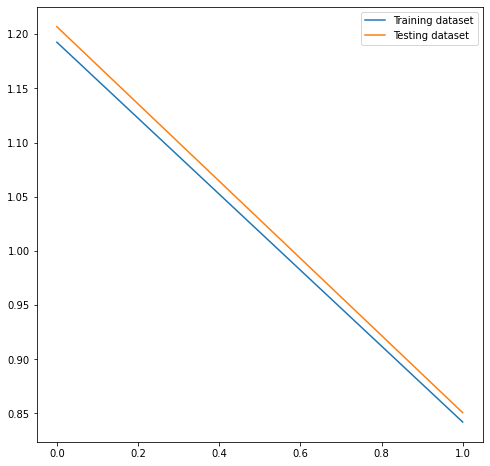

<Figure size 432x288 with 0 Axes>

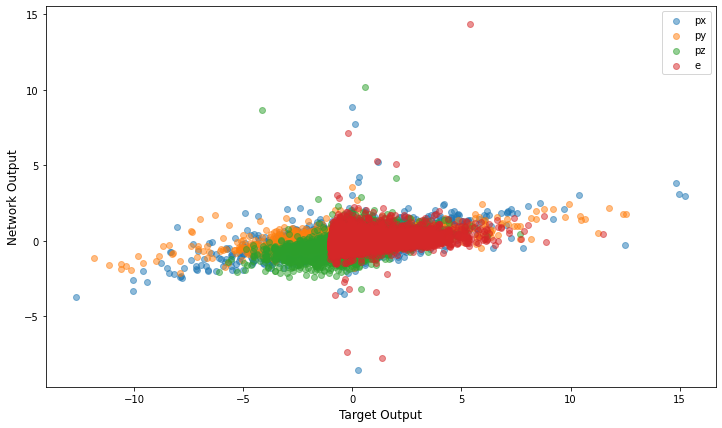

<Figure size 432x288 with 0 Axes>

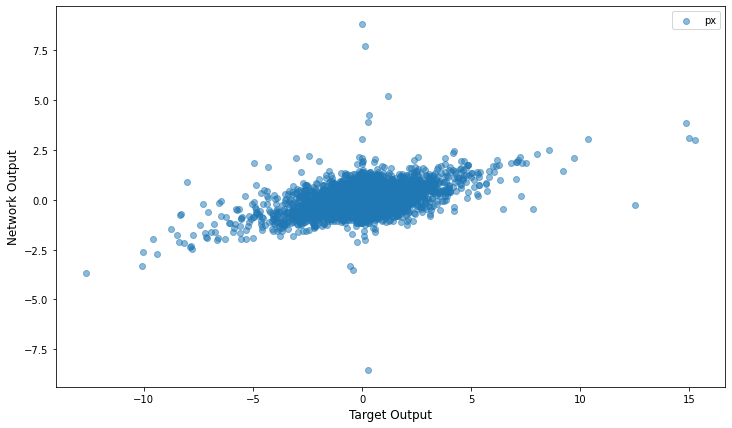

<Figure size 432x288 with 0 Axes>

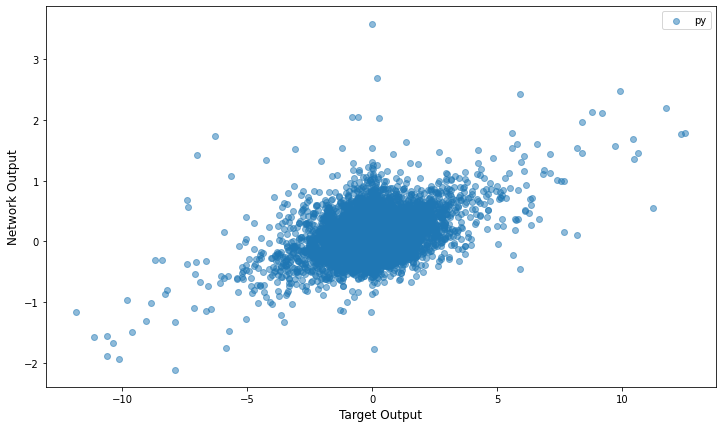

<Figure size 432x288 with 0 Axes>

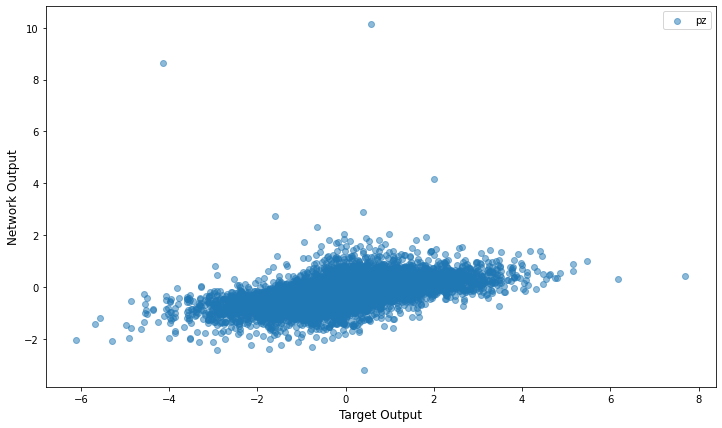

<Figure size 432x288 with 0 Axes>

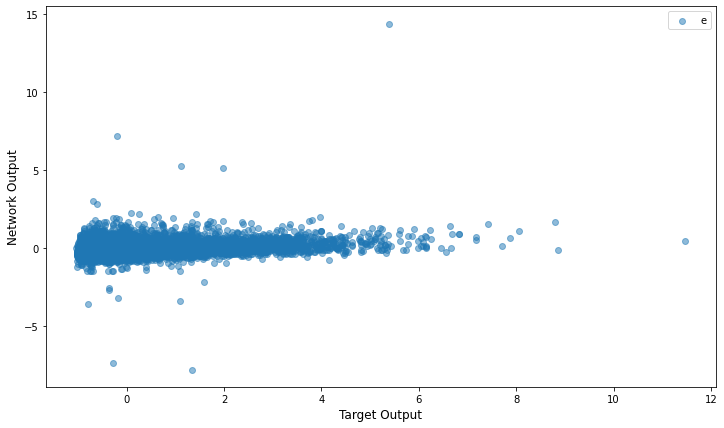

<Figure size 432x288 with 0 Axes>

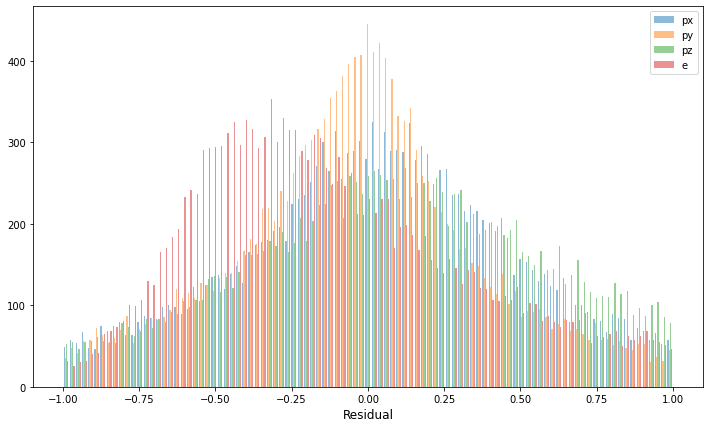

<Figure size 432x288 with 0 Axes>

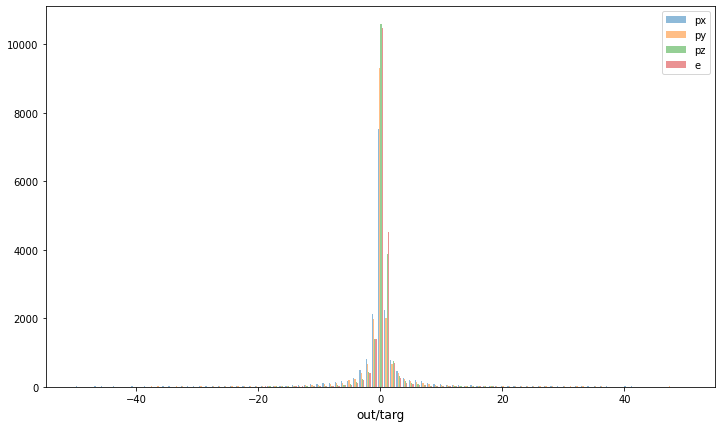

<Figure size 432x288 with 0 Axes>

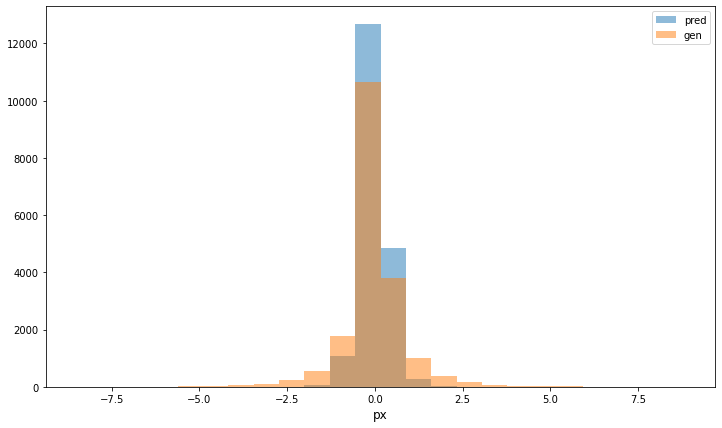

<Figure size 432x288 with 0 Axes>

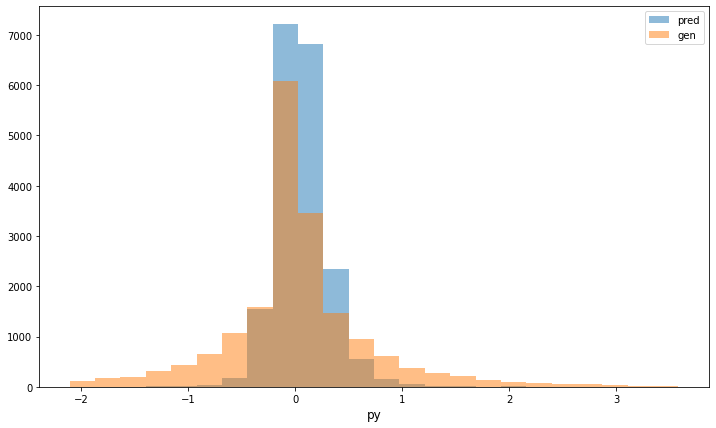

<Figure size 432x288 with 0 Axes>

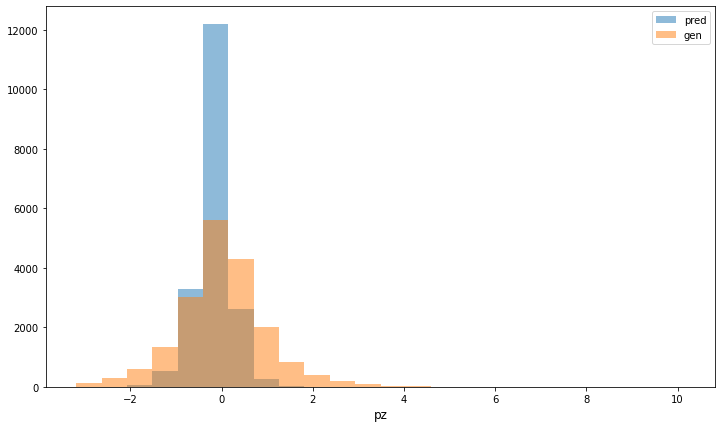

<Figure size 432x288 with 0 Axes>

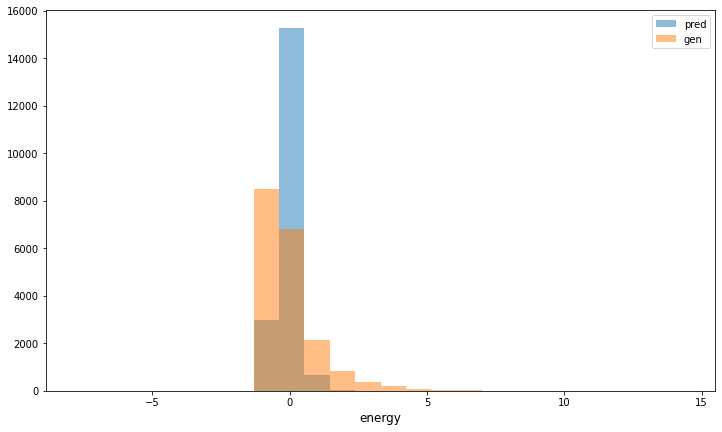

100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


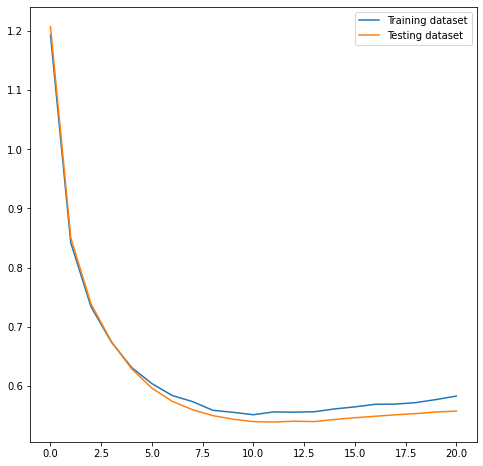

<Figure size 432x288 with 0 Axes>

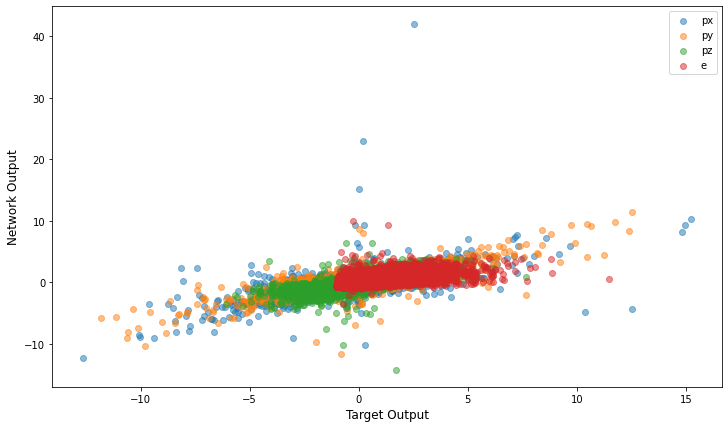

<Figure size 432x288 with 0 Axes>

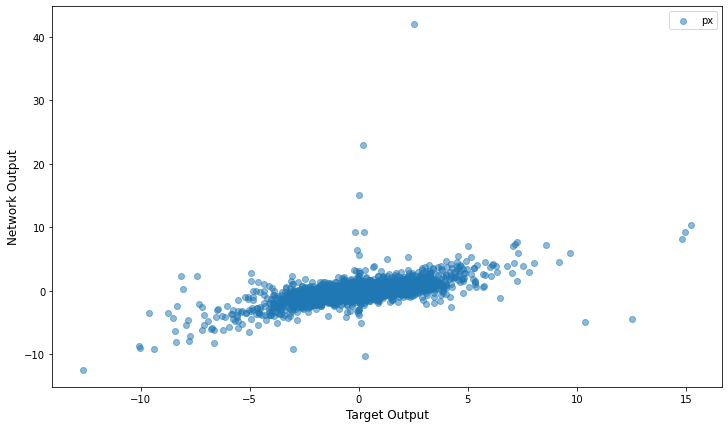

<Figure size 432x288 with 0 Axes>

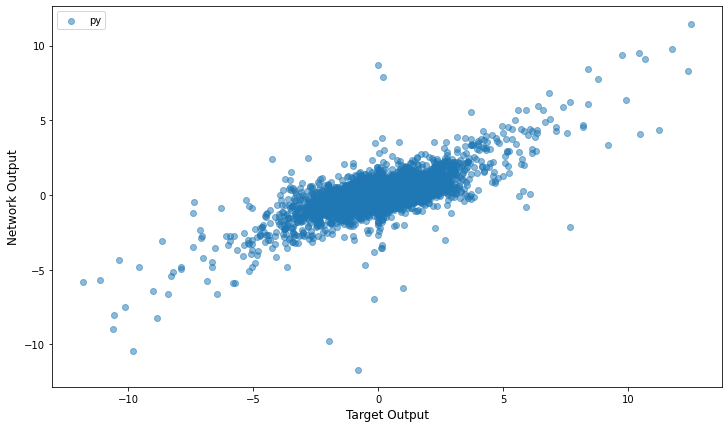

<Figure size 432x288 with 0 Axes>

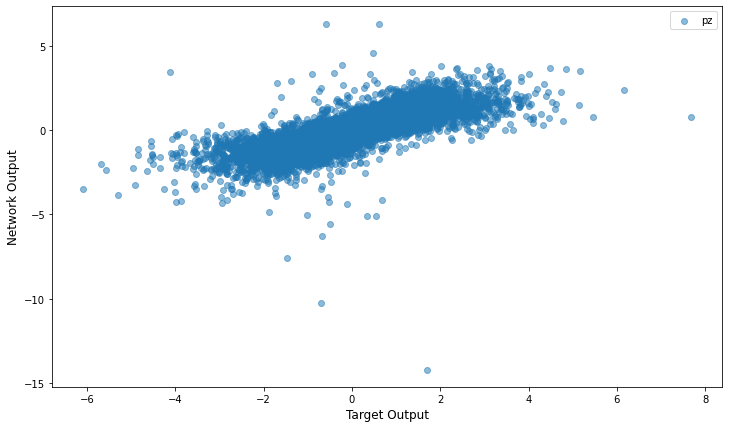

<Figure size 432x288 with 0 Axes>

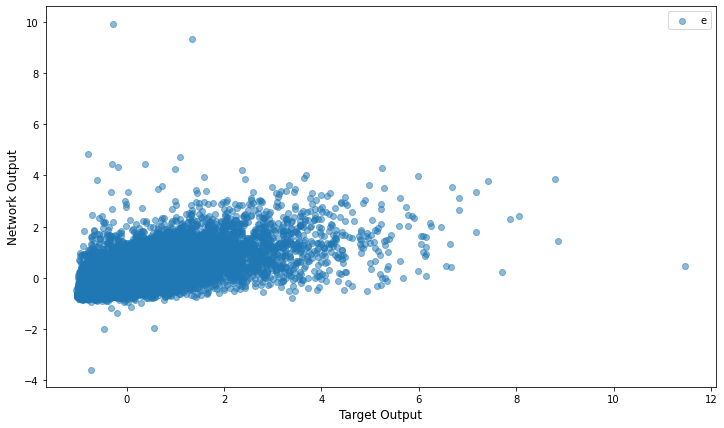

<Figure size 432x288 with 0 Axes>

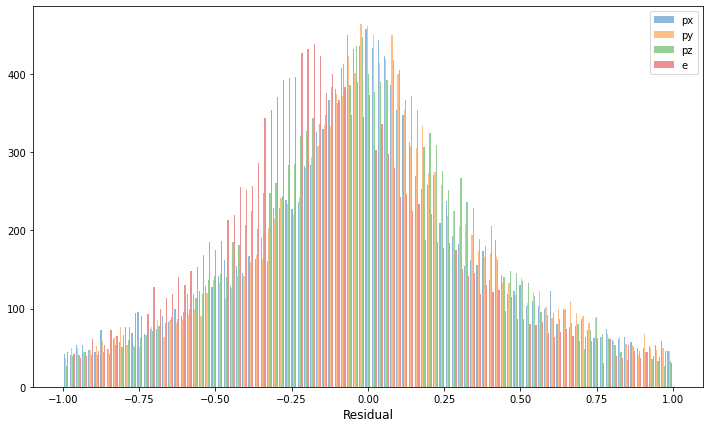

<Figure size 432x288 with 0 Axes>

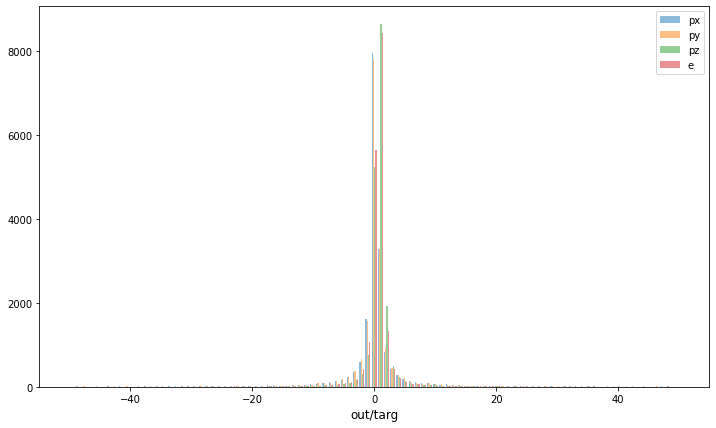

<Figure size 432x288 with 0 Axes>

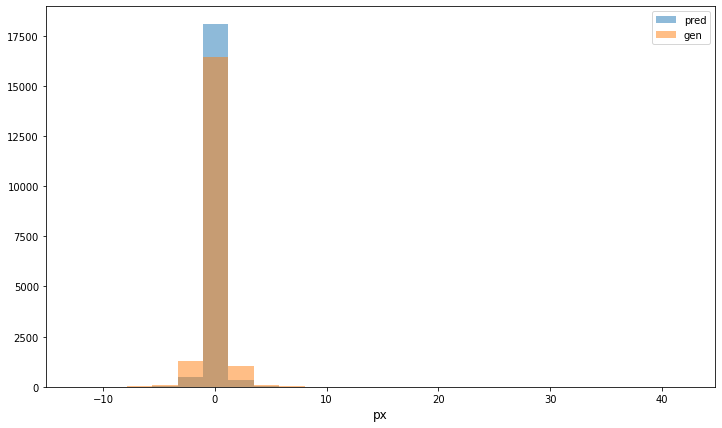

<Figure size 432x288 with 0 Axes>

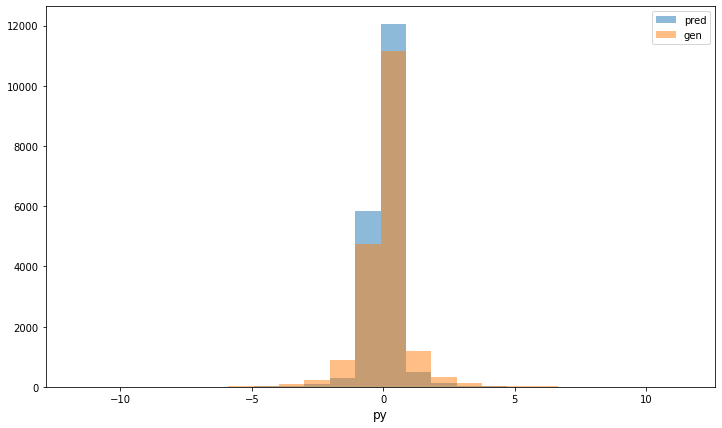

<Figure size 432x288 with 0 Axes>

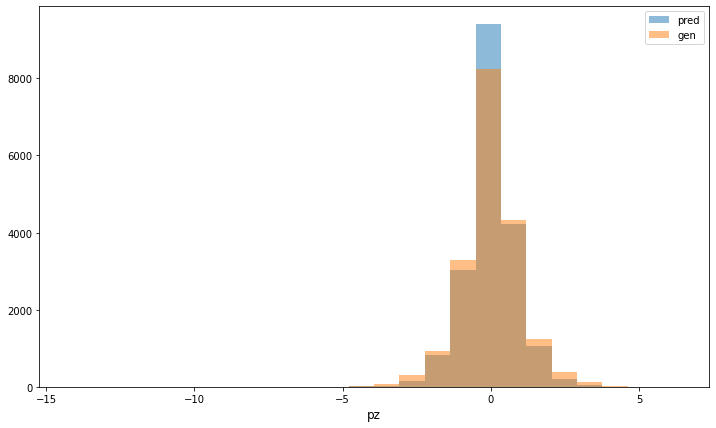

<Figure size 432x288 with 0 Axes>

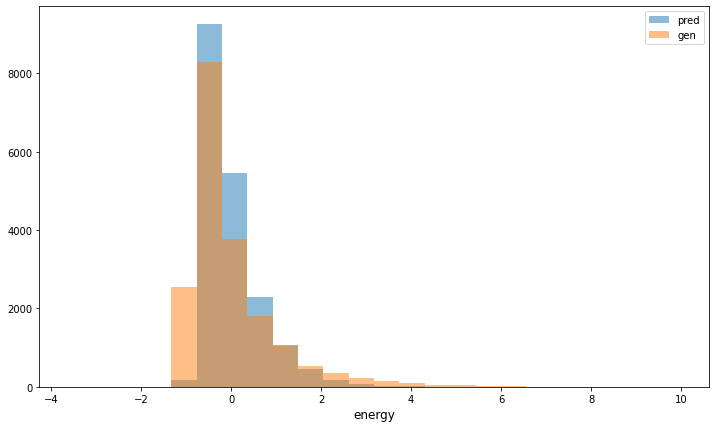

Found nan% dead neurons!


/tmp/ipykernel_1996296/3349778203.py:172: RuntimeWarning: invalid value encountered in double_scalars
  print(f'Found {100 * np.sum([x for x,_ in dead]) / np.sum([y for _,y in dead])}% dead neurons!')


In [39]:
# Register hooks for all ReLU layers
activations = []

def activation_hook(module, input, output):
    activations.append(output)
        
def main():
    torch.manual_seed(42)
    #args = handleOptions()
    #parser.add_argument("--reload",  action='store_true', default=False, help="Force conversion of hdf to pytorch")
    args = {}
    files = "top_quark_reco_events_NAOD-00000_89*"
    files = "top_quark_reco_events_NAOD-00000_898.root"
    #files = "top_quark_reco_events_NAOD-00000_*"
    #files = "top_quark_reco_events.root"
    #files = "NAOD-00000_1016.root"
    device = 'cpu'
    name = ''
    out_path = '.'
    features = "ttbar_pt, ttbar_eta, ttbar_phi, ttbar_pz, ttbar_mass, ttbar_energy, Lep1_pt,Lep2_pt,Lep1_eta,Lep2_eta,Lep2_phi,Lep2_phi,Jet1_pt,Jet1_eta,Jet1_phi,Jet2_pt,Jet2_eta,Jet2_phi,Jet3_pt,Jet3_eta,Jet3_phi,Jet4_pt,Jet4_eta,Jet4_phi,met_pt,PT_pt"
    features = "top1_pt,lep1_pt"
    input_features = "ttbar_px,ttbar_py,ttbar_pz,ttbar_energy"
    #input_features = "ttbar_px"
    input_nodes = "lepton1_px,lepton1_py,lepton1_pz,lepton1_energy,lepton2_px,lepton2_py,lepton2_pz,lepton2_energy,jet1_px,jet1_py,jet1_pz,jet1_energy,jet2_px,jet2_py,jet2_pz,jet2_energy,jet3_px,jet3_py,jet3_pz,jet3_energy,jet4_px,jet4_py,jet4_pz,jet4_energy,met_px,met_py"

  
    input_nodes = "lepton1_px,lepton1_py,lepton1_pz,lepton1_energy,lepton2_px,lepton2_py,lepton2_pz,lepton2_energy,jet1_px,jet1_py,jet1_pz,jet1_energy,jet2_px,jet2_py,jet2_pz,jet2_energy,jet3_px,jet3_py,jet3_pz,jet3_energy,jet4_px,jet4_py,jet4_pz,jet4_energy,jet5_px,jet5_py,jet5_pz,jet5_energy,jet6_px,jet6_py,jet6_pz,jet6_energy,jet7_px,jet7_py,jet7_pz,jet7_energy,jet8_px,jet8_py,jet8_pz,jet8_energy,met_px,met_py"
    features = ','.join([input_features, input_nodes])
    print(features)
    #features = "ttbar_x, ttbar_y, ttbar_z, Lep1_x,Lep2_x,Lep1_y,Lep2_y,Lep2_z,Lep2_z,Jet1_x,Jet1_y,Jet1_z,Jet2_x,Jet2_y,Jet2_z,Jet3_x,Jet3_y,Jet3_z,Jet4_x,Jet4_y,Jet4_z,met_x"
    feature_division = len(input_features.split(","))
    forceRebuild = False
    batch_size = 64*2
    epochs = 20
    learning_rate = 0.0001
    factor = 0.01
    patience = 10
    norm = True
    profile = False
    args['files'] = files
    args['device'] = device
    args['name'] = name
    args['out_path'] = out_path
    args['features'] = features
    args['forceRebuild'] = forceRebuild
    args['batch_size'] = batch_size
    args['epochs'] = epochs
    args['learning_rate'] = learning_rate
    args['factor'] = factor
    args['patience'] = patience
    args['norm'] = norm
    args['profile'] = profile

    # Now we decide how (if) we will use the gpu
    if device != 'cpu' and not torch.cuda.is_available():
        print("Warning, you tried to use cuda, but its not available. Will use the CPU")
        device = 'cpu'
    print(f'{device=}')

    # If we use the cpu we dont use the whole UI (at psi)
    torch.set_num_threads(8)

    # all the stuff below should be configurable in the future
    # we get the model = net + cost function
    #from analysis.ttbarML.net import Model
    from net import Model
    #from models.net import Model
    model = Model(features = len(features.split(",")), feature_division = feature_division, device = device)
        
    # Register hooks for all ReLU layers
    for layer in model.net.modules():
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
            layer.register_forward_hook(activation_hook)

    # now we get the data
    #from analysis.ttbarML.data import eftDataLoader
    from data import eftDataLoader
    signal_dataset = eftDataLoader( args )
    #sm_mean = torch.mean(signal_dataset.sm_weight); bsm_mean = torch.mean(signal_dataset.bsm_weight)
    mean = torch.mean(signal_dataset.features)
    dataset_size = len(signal_dataset)
    train_size = int(0.7 * dataset_size)
    train, test    = torch.utils.data.random_split( signal_dataset, [train_size, (dataset_size-train_size)], generator=torch.Generator().manual_seed(42))
    train, test    = torch.utils.data.random_split( signal_dataset, [train_size, (dataset_size-train_size)], generator=torch.Generator().manual_seed(0))
    #dataloader     = DataLoader(  train  , batch_size=args['batch_size'], shuffle=True)

    #normalize features
    mu,std = torch.mean(train[:]), torch.std(train[:])
    norm_train_targ, norm_train = train[:][:,:feature_division].norm(p=2, dim=1, keepdim=True), train[:][:,feature_division:].norm(p=2, dim=1, keepdim=True)
    #train_targ, train = torch.nn.functional.normalize(train[:][:,:feature_division],dim=1), torch.nn.functional.normalize(train[:][:,feature_division:],dim=1)
    train_targ, train_input = train[:][:,:feature_division], train[:][:,feature_division:]
    #train_targ, train_input = torch.nn.functional.normalize(train_targ[:],dim=1), torch.nn.functional.normalize(train_input[:],dim=1)
    #train_targ  = train_targ[:100]
    #train_input = train_input[:100]
    
    if not args['norm']:
        train_targ = train[:][:,:feature_division]
        train_input = train[:][:,feature_division:]
        norm_train_targ, norm_train_input = torch.ones_like(norm_train_targ), torch.ones_like(norm_train_targ)
    norm_test_targ, norm_test = test[:][:,:feature_division].norm(p=2, dim=1, keepdim=True), test[:][:,feature_division:].norm(p=2, dim=1, keepdim=True)
    #test_targ, test = torch.nn.functional.normalize(test[:][:,:feature_division],dim=1), torch.nn.functional.normalize(test[:][:,feature_division:],dim=1)
    test_targ, test_input = test[:][:,:feature_division], test[:][:,feature_division:]
    #test_targ, test_input = torch.nn.functional.normalize(test_targ[:],dim=1), torch.nn.functional.normalize(test_input[:],dim=1)
    
    #train_targ = (train_targ - torch.mean(train_targ)) / torch.std(train_targ)
    #train_input = (train_input - torch.mean(train_input)) / torch.std(train_input)
    #test_targ = (test_targ - torch.mean(test_targ)) / torch.std(test_targ)
    #test_input = (test_input - torch.mean(test_input)) / torch.std(test_input)

    if not args['norm']:
        test_targ = test[:][:,:feature_division]
        test_input = test[:][:,feature_division:]
        norm_test_targ, norm_test_input = torch.ones_like(norm_test_targ), torch.ones_like(norm_test_targ)
        
    train_targ_mean, train_targ_std = torch.mean(train_targ.T, dim=1).T, torch.std(train_targ.T, dim=1).T
    train_input_mean, train_input_std = torch.mean(train_input.T, dim=1).T, torch.std(train_input.T, dim=1).T
    test_targ_mean, test_targ_std = torch.mean(test_targ.T, dim=1).T, torch.std(test_targ.T, dim=1).T
    test_input_mean, test_input_std = torch.mean(test_input.T, dim=1).T, torch.std(test_input.T, dim=1).T
    train_targ = (train_targ - train_targ_mean) / train_targ_std
    train_input = (train_input - train_input_mean) / train_input_std
    test_targ = (test_targ - test_targ_mean) / test_targ_std
    test_input = (test_input - test_input_mean) / test_input_std

    # Put back energy mean to avoid bias
    #train_targ[:,3] = train_targ[:,3] + train_targ_mean[3] / train_targ_std[3]
    #train_targ[:,3] = train_input[:,3] + train_input_mean[3] / train_input_std[3]
    #test_targ[:,3] = test_targ[:,3] + test_targ_mean[3] / test_targ_std[3]
    #test_input[:,3] = test_input[:,3] + test_input_mean[3] / test_input_std[3]
    
    dataloader     = DataLoader(  torch.cat([train_targ,train_input], dim=1)  , batch_size=args['batch_size'], shuffle=True)
    #test  = torch.nn.functional.normalize(test[:])
    optimizer = optim.Adam(model.net.parameters(), lr=args['learning_rate'])
    #optimizer = optim.SGD(model.net.parameters(), lr=args.learning_rate, momentum=args.momentum)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=args['factor'], patience=args['patience'])
    loss_train = [model.cost_from_batch(train_targ, train_input, args['device']).item()]
    #loss_train = [model.cost_from_batch(train[:,feature_division:], train[:,0:feature_division] , args.device).item()]
    loss_test  = [model.cost_from_batch(test_targ , test_input,  args['device']).item()]
    dead = []
    print([x/1024/1024/1024 for x in torch.cuda.mem_get_info()])
    for epoch in tqdm(range(args['epochs'])):
        #for i,(tops, features) in enumerate(dataloader):
        for i,(features) in enumerate(dataloader):
            #print(f'{len(features)}')
            #print(f'Training {epoch=} on {features}')
            targets = features[:,0:feature_division]
            features = features[:,feature_division:]
            optimizer.zero_grad()
            loss = model.cost_from_batch(targets, features, args['device'])
            if args['profile']:
                dead.append([((activation.abs() < 0.01).sum().item(), activation.numel()) for activation in activations])
                #for i, activation in enumerate(activations):
                #    # Count number of dead neurons (all zeros)
                #    #dead_neurons = (activation == 0).sum().item()
                #    dead_neurons = (activation.abs() < 0.01).sum().item()
                #    total_neurons = activation.numel()
                #    dead.append((dead_neurons, total_neurons))
                #    #print(f"Layer {i+1}: {float(dead_neurons)/total_neurons*100}% dead neurons")
                ##print(loss.detach().cpu().numpy())
                #print(f'Found {100 * np.sum([x for x,_ in dead[-1]]) / np.sum([y for _,y in dead[-1]])}% dead neurons!')
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
        loss_train.append( model.cost_from_batch(train_targ, train_input , args['device']).item())
        loss_test .append( model.cost_from_batch(test_targ , test_input,  args['device']).item())
        scheduler.step(loss_train[epoch])
        if epoch%50==0:
            if args['profile']: print(f'Found {100 * np.sum([x for x,_ in dead[-1]]) / np.sum([y for _,y in dead[-1]])}% dead neurons!')
            save_and_plot( model.net, loss_test, loss_train, f"test_epoch_{epoch}", test_input, test_targ, feature_division, norm_test, norm_test_targ, show=True)
            #print(optimizer.param_groups[0]['lr'])
            
    save_and_plot( model.net, loss_test, loss_train, f"test_last", test_input, test_targ, feature_division, norm_test, norm_test_targ, show=True)
    print(f'Found {100 * np.sum([x for x,_ in dead]) / np.sum([y for _,y in dead])}% dead neurons!')
    
if __name__=="__main__":
    main()